# 2. Building the Machine Learning Model
This step focuses on developing a Machine Learning (ML) model to predict benthic habitat classes from PlanetScope image data using the Extreme Gradient Boosting (XGBoost) algorithm. The process also includes hyperparameter tuning to identify the best parameter configuration for optimal model performance. <br>

First, we will load the training and testing datasets prepared in the previous step. Make sure that the directory path is correct before proceeding.


In [1]:
# Load the training and testing data that has been saved in Numpy Array format
import numpy as np

X_train = np.load(r"Train\X_train_resampled.npy")
X_test = np.load(r"Train\X_test.npy")
y_train = np.load(r"Train\y_train_resampled.npy")
y_test = np.load(r"Train\y_test.npy")
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(4692, 8) (5237, 8) (4692,) (5237,)


The classes in the sample data consist of 6 classes, so we will make sure if this is correct.

In [2]:
# Check the number of classes
print(f"{np.unique(y_train)} Number of classes")

[0 1 2 3 4 5] Number of classes


## Import Machine Learning Library

There are many machine learning (ML) algorithm options for tasks such as classification, including benthic habitat classification. Here, we choose the **Extreme Gradient Boosting (XGBoost)** algorithm to develop a classification model. <br>  

Compared to established decision tree-based algorithms like Random Forest (RF), XGBoost uses a boosting technique to iteratively build the model and correct errors from the previous iteration. However, this comes with the trade-off of requiring relatively more time and computational resources. <br>

Import the `xgboost` library and `XGBClassifier` into the environment so that its functions and modules can be accessed.

In [3]:
# If not installed yet (delete comment below)
# !pip install xgboost
import xgboost
from xgboost import XGBClassifier


Check the available parameters of this algorithm that can be customized. <br>

[Source](https://xgboost.readthedocs.io/en/latest/parameter.html)



In [4]:
# Check available xgboost parameters
xgb_params = XGBClassifier()
xgb_params.get_xgb_params()

{'objective': 'binary:logistic',
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'eval_metric': None,
 'gamma': None,
 'grow_policy': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

We can already create a model using the default parameters provided by `xgboost` above. The advantage of this approach is its practicality; however, the model may not necessarily achieve optimal performance or the highest accuracy. <br>

## Hyperparameter Tuning
The two major ways of hyperparameter tuning include the manual and the automatic. In a manual approach, we test various combinations of parameters ourselves, which may be pretty time-consuming and not so effective. The automatic approach, on the other hand, does the job of finding out the best parameters on its own using techniques like **Grid Search** or **Random Search**. <br>

The automatic approach is favored because:

- **Efficiency**: It saves time by systematically going through all possible combinations or random selections of parameters.

- **Better Results**: It finds the best parameters that optimize accuracy using cross-validation methods.

- **Reduced Human Error**: It reduces the potential errors that may arise with the manual process.

The code below uses `GridSearchCV` module from `sklearn` library, a method for automated hyperparameter tuning: given a range of parameter options, it will run many different models based on these parameters and return the best.

In [5]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Create the initial xgboost model
xgb_model = XGBClassifier(random_state=42)

### Define Parameter List
Define a **parameter grid** for hyperparameter tuning. Listed below are several values of each hyperparameter that will be tried out during tuning in search of the best combination for the model:

* **`n_estimators`**: The number of trees within the model: 50, 100, 300
* **`max_depth`**: The maximum depth of the trees: 3, 6, 9
* **`eta`** (learning rate): Step size of updates while moving toward a minimum of a loss function: 0.1, 0.3, 0.5
* **`gamma`**: Minimum loss reduction required to make a further partition (options: 0, 0.1, 0.2)
* **`subsample`**: Fraction of samples used for each tree (options: 0.8, 1.0)
* **`colsample_bytree`**: Fraction of features used for each tree (options: 0.8, 1.0)
<br>

[Source](https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html)



In [6]:
# Define a list of parameters for hyperparameter tuning
# List of the parameters
param_list = {
    'n_estimators': [50, 100, 300], #  Number of trees to build in the model. Trying 50, 100, and 300 trees.
    'max_depth': [3, 6, 9], # Maximum depth of each tree. Trying depths of 3, 6, and 9.
    'eta': [0.1, 0.3, 0.5], # Controls the step size of the learning process. Trying values of 0.1, 0.3, and 0.5.
    'gamma': [0, 0.1, 0.2], # Minimum loss reduction required for further partitioning a leaf node. Trying values of 0, 0.1, and 0.2.
    'subsample': [0.8, 1.0], # Fraction of the training data to use for fitting each tree. Trying 0.8 and 1.0.
    'colsample_bytree': [0.8, 1.0], # Fraction of features to use for each tree. Trying 0.8 and 1.0.
}


Use 5-fold cross-validation in GridSearchCV to ensure the model's performance is evaluated more robustly. Here's why:

- **Divide the data** into 5 equal parts (folds).
- **Train the model** on 4 folds and test it on the remaining fold. This is repeated 5 times, with each fold used for testing once.
- This helps **reduce overfitting** and gives a better estimate of the model's performance by averaging the results.

Using cross-validation ensures that the chosen hyperparameters are effective across different subsets of the data. <br>

[Source](https://scikit-learn.org/1.5/modules/cross_validation.html)

In [7]:
# 5-fold cross-validation GridSearchCV
grid_search = GridSearchCV(
    xgb_model,            # The model you want to tune (XGBoost classifier)
    param_list,           # The grid of hyperparameters to search
    cv=5,                 # Number of folds for cross-validation (5-fold)
    scoring='accuracy',   # The metric used to evaluate model performance (accuracy)
    n_jobs=-1,            # Use all available CPU cores for parallel processing
    verbose=5             # Display progress and information (higher value gives more details)
)


### Execute Hyperparameter Tuning  
Run hyperparameter tuning using the `GridSearchCV` that has been created. To add more information about the processing, also include a command to record the duration of time taken to search for the best parameters.

In [8]:
import time

# Record the start time
start = time.time()

# Fit the XGBoost model using grid search
grid_search.fit(X_train, y_train)

# Record the end time
finish = time.time()

# Calculate the time taken for the process
time_taken = finish - start
print(f"Total time for execution: {time_taken:.3f} seconds")

# Display the best parameters found during grid search
print("Optimal parameters:", grid_search.best_params_)
print("Highest cross-validation accuracy:", grid_search.best_score_)


Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Total time for execution: 210.446 seconds
Optimal parameters: {'colsample_bytree': 1.0, 'eta': 0.1, 'gamma': 0, 'max_depth': 9, 'n_estimators': 300, 'subsample': 0.8}
Highest cross-validation accuracy: 0.8531600327890443


### Model Evaluation 
This script defines a function to evaluate classification performance, making it easier for future evaluations. It calculates overall accuracy, generates a classification report (precision, recall, F1-score), and visualizes the confusion matrix. This helps to assess how well the model performs and where it makes errors.
Create `evaluate_classification` function to evaluate the performance of the model. The function will generate a classification report:
- **Overall Accuracy**: Calculates and prints the overall accuracy score of the model.
- **Classification Report**: Generates a classification report that includes precision (User Accuracy), recall (Producer Accuracy), and F1-score for each class.
- **Confusion Matrix**: Computes the confusion matrix and visualizes it using a heatmap, showing the number of correct and incorrect predictions for each class.


In [ ]:
# Install metrics module from scikit-learn to do model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# List available colormaps in Matplotlib (also used in Seaborn)
cmap_list = plt.colormaps()

# Print available colormaps
for cmap in cmap_list:
    print(cmap)


magma
inferno
plasma
viridis
cividis
twilight
twilight_shifted
turbo
Blues
BrBG
BuGn
BuPu
CMRmap
GnBu
Greens
Greys
OrRd
Oranges
PRGn
PiYG
PuBu
PuBuGn
PuOr
PuRd
Purples
RdBu
RdGy
RdPu
RdYlBu
RdYlGn
Reds
Spectral
Wistia
YlGn
YlGnBu
YlOrBr
YlOrRd
afmhot
autumn
binary
bone
brg
bwr
cool
coolwarm
copper
cubehelix
flag
gist_earth
gist_gray
gist_heat
gist_ncar
gist_rainbow
gist_stern
gist_yarg
gnuplot
gnuplot2
gray
hot
hsv
jet
nipy_spectral
ocean
pink
prism
rainbow
seismic
spring
summer
terrain
winter
Accent
Dark2
Paired
Pastel1
Pastel2
Set1
Set2
Set3
tab10
tab20
tab20b
tab20c
grey
gist_grey
gist_yerg
Grays
magma_r
inferno_r
plasma_r
viridis_r
cividis_r
twilight_r
twilight_shifted_r
turbo_r
Blues_r
BrBG_r
BuGn_r
BuPu_r
CMRmap_r
GnBu_r
Greens_r
Greys_r
OrRd_r
Oranges_r
PRGn_r
PiYG_r
PuBu_r
PuBuGn_r
PuOr_r
PuRd_r
Purples_r
RdBu_r
RdGy_r
RdPu_r
RdYlBu_r
RdYlGn_r
Reds_r
Spectral_r
Wistia_r
YlGn_r
YlGnBu_r
YlOrBr_r
YlOrRd_r
afmhot_r
autumn_r
binary_r
bone_r
brg_r
bwr_r
cool_r
coolwarm_r
copper_r
cu

In [10]:
# Create evaluation function for future convenience
def evaluate_classification(y_true, y_pred):
    # Calculate overall accuracy
    OA = accuracy_score(y_true, y_pred)

    # Print Overall Accuracy
    print(f"Overall Accuracy: {OA:.4f}")

    # Calculate classification report: precision, recall, f1-score
    report = classification_report(y_true, y_pred, digits=4)
    print(report)

    # Calculate confusion matrix for each class
    class_names = ['Rock', 'Rubble', 'Coral-Algae', 'Sand', 'Seagrass', 'Microalgal Mats']
    cm = confusion_matrix(y_true, y_pred)

    # Visualize confusion matrix using seaborn heatmap
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', cbar=False,
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix', fontsize=14)
    plt.show()


Use best model from the grid search to make predictions on the test datasets and then evaluates the performance using `evaluate_classification`

Overall Accuracy: 0.6019
              precision    recall  f1-score   support

           0     0.3232    0.2927    0.3072       328
           1     0.5787    0.6164    0.5969      1551
           2     0.5925    0.5951    0.5938      1825
           3     0.3443    0.2401    0.2829       304
           4     0.7693    0.7763    0.7728      1207
           5     0.1600    0.1818    0.1702        22

    accuracy                         0.6019      5237
   macro avg     0.4613    0.4504    0.4540      5237
weighted avg     0.5961    0.6019    0.5982      5237



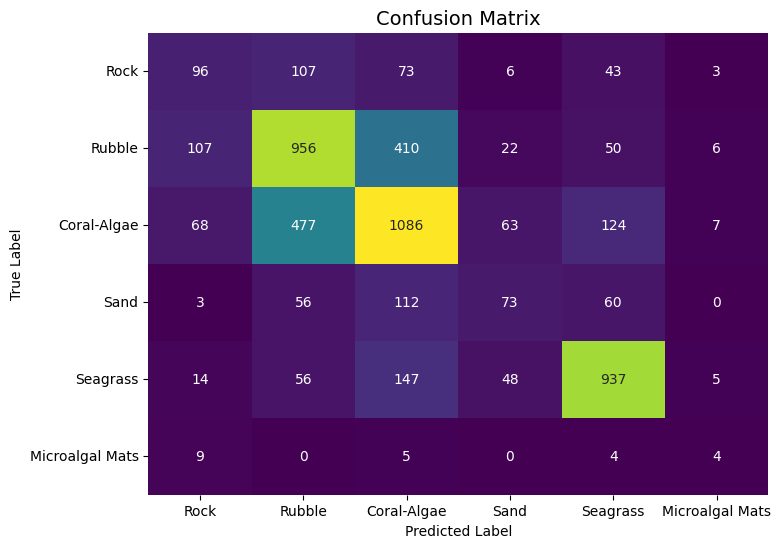

In [11]:
# Retrieve the optimal XGBoost model from grid search
optimized_xgb = grid_search.best_estimator_

# Use the optimized model to make predictions on the test dataset
predictions = optimized_xgb.predict(X_test)

# Evaluate the model's performance by comparing the predicted and actual values
evaluate_classification(y_test, predictions)


## Save the Model
Once the model is trained, save it in the `.pkl` extension or "pickle," which is a Python method for saving objects like ML models. By saving it with this file extension, it becomes easier to use it elsewhere or retrain it, making it more efficient.

In [12]:
# Import joblib to save or load objects like ML models
# It's quite efficient for saving large models that have many trees such as XGBoost
import joblib

# Save trained model to a .pkl file
joblib.dump(optimized_xgb, r"Model\benthic_xgb_model.pkl")

['Model\\benthic_xgb_model.pkl']